##### Mediapipe 辨識手指，用手指在影片中畫圖
這篇教學會延伸「Mediapipe 手勢辨識」和「在影片中即時繪圖」文章，當辨識到「食指」時，就讓食指尖端可以在影像中畫出線條，\
如果換成別的手勢就會停止，除此之外，額外設計成「如果食指碰到指定顏色，畫出的線條就會變成指定顏色」的效果。

參考：\
[Mediapipe 手勢辨識](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-gesture.html)\
[在影片中即時繪圖](https://steam.oxxostudio.tw/category/python/ai/opencv-video-draw.html)

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 辨識手指，用手指在影像中畫圖 
因為整體程式碼較多，因此將詳細說明寫在程式碼的註解內，程式碼的重點如下：

* 沿用「[Mediapipe 手勢辨識](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-gesture.html)」文章的範例程式。
* 使用 NumPy 產生黑色畫布，尺寸和影像相同，顏色使用包含 alpha 色版的 (0,0,0,0)。
* 在畫面中放入三個不同顏色的正方形，預設起始顏色為紅色 (0,0,255,255)。
* 偵測手指如果是「1」的手勢，取得食指末端的座標。
* 將座標記錄到串列中，透過串列取值 ( 取出倒數第一和第二個 )，在黑色畫布上繪製直線。
* 參考「[在影片中即時繪圖](https://steam.oxxostudio.tw/category/python/ai/opencv-video-draw.html)」文章範例，將黑色畫布與影像合成為新的影像。

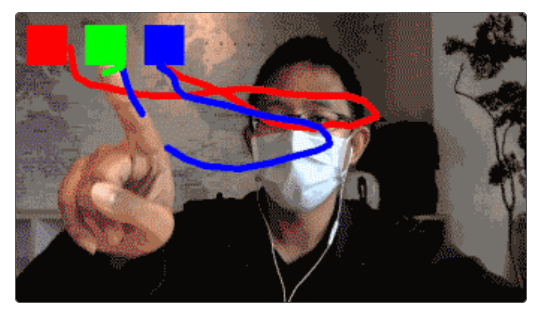

In [ ]:
import cv2
import mediapipe as mp
import math
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# 根據兩點的座標，計算角度
def vector_2d_angle(v1, v2):
    """
    計算兩個 2D 向量之間的角度。

    參數:
    v1: tuple - 第一個向量的座標 (x, y)。
    v2: tuple - 第二個向量的座標 (x, y)。

    返回:
    angle_: float - 兩個向量之間的角度（度數）。
    """
    v1_x = v1[0]
    v1_y = v1[1]
    v2_x = v2[0]
    v2_y = v2[1]
    try:
        angle_ = math.degrees(math.acos((v1_x * v2_x + v1_y * v2_y) / (((v1_x ** 2 + v1_y ** 2) ** 0.5) * ((v2_x ** 2 + v2_y ** 2) ** 0.5))))
    except:
        angle_ = 180
    return angle_

# 根據傳入的 21 個節點座標，得到該手指的角度
def hand_angle(hand_):
    """
    根據傳入的 21 個節點座標，計算每根手指的角度。

    參數:
    hand_: list - 包含 21 個節點座標的列表，每個節點為 (x, y) 座標。

    返回:
    angle_list: list - 包含每根手指角度的列表，順序為 [大拇指, 食指, 中指, 無名指, 小拇指]。
    """
    angle_list = []
    # thumb 大拇指角度
    angle_ = vector_2d_angle(
        ((int(hand_[0][0]) - int(hand_[2][0])), (int(hand_[0][1]) - int(hand_[2][1]))),
        ((int(hand_[3][0]) - int(hand_[4][0])), (int(hand_[3][1]) - int(hand_[4][1])))
    )
    angle_list.append(angle_)
    # index 食指角度
    angle_ = vector_2d_angle(
        ((int(hand_[0][0]) - int(hand_[6][0])), (int(hand_[0][1]) - int(hand_[6][1]))),
        ((int(hand_[7][0]) - int(hand_[8][0])), (int(hand_[7][1]) - int(hand_[8][1])))
    )
    angle_list.append(angle_)
    # middle 中指角度
    angle_ = vector_2d_angle(
        ((int(hand_[0][0]) - int(hand_[10][0])), (int(hand_[0][1]) - int(hand_[10][1]))),
        ((int(hand_[11][0]) - int(hand_[12][0])), (int(hand_[11][1]) - int(hand_[12][1])))
    )
    angle_list.append(angle_)
    # ring 無名指角度
    angle_ = vector_2d_angle(
        ((int(hand_[0][0]) - int(hand_[14][0])), (int(hand_[0][1]) - int(hand_[14][1]))),
        ((int(hand_[15][0]) - int(hand_[16][0])), (int(hand_[15][1]) - int(hand_[16][1])))
    )
    angle_list.append(angle_)
    # pink 小拇指角度
    angle_ = vector_2d_angle(
        ((int(hand_[0][0]) - int(hand_[18][0])), (int(hand_[0][1]) - int(hand_[18][1]))),
        ((int(hand_[19][0]) - int(hand_[20][0])), (int(hand_[19][1]) - int(hand_[20][1])))
    )
    angle_list.append(angle_)
    return angle_list

# 根據手指角度的串列內容，返回對應的手勢名稱
def hand_pos(finger_angle):
    """
    根據手指角度的串列內容，返回對應的手勢名稱。

    參數:
    finger_angle: list - 包含每根手指角度的列表，順序為 [大拇指, 食指, 中指, 無名指, 小拇指]。

    返回:
    str - 對應的手勢名稱，這裡僅返回 '1' 或空字串。
    """
    f1 = finger_angle[0]   # 大拇指角度
    f2 = finger_angle[1]   # 食指角度
    f3 = finger_angle[2]   # 中指角度
    f4 = finger_angle[3]   # 無名指角度
    f5 = finger_angle[4]   # 小拇指角度

    # 小於 50 表示手指伸直，大於等於 50 表示手指捲縮
    if f1 >= 50 and f2 < 50 and f3 >= 50 and f4 >= 50 and f5 >= 50:
        return '1'
    else:
        return ''

cap = cv2.VideoCapture(0)            # 讀取攝影機
fontFace = cv2.FONT_HERSHEY_SIMPLEX  # 印出文字的字型
lineType = cv2.LINE_AA               # 印出文字的邊框

# mediapipe 啟用偵測手掌
with mp_hands.Hands(
    model_complexity=0,  # 模型複雜度，0 為最簡單的模型，適合效能較低的設備
    min_detection_confidence=0.5,  # 最小偵測信心值，範圍為 [0.0, 1.0]
    min_tracking_confidence=0.5  # 最小追蹤信心值，範圍為 [0.0, 1.0]
) as hands:

    if not cap.isOpened():
        print("Cannot open camera")  # 無法開啟攝影機時，印出錯誤訊息並退出
        exit()
    w, h = 1080, 720                                        # 影像尺寸
    draw = np.zeros((h, w, 4), dtype='uint8')               # 繪製全黑背景，尺寸和影像相同
    dots = []                                               # 使用 dots 空串列記錄繪圖座標點
    cv2.rectangle(draw, (20, 20), (60, 60), (0, 0, 255, 255), -1)   # 在畫面上方放入紅色正方形,-1 的意思是將矩形填滿。
    cv2.rectangle(draw, (80, 20), (120, 60), (0, 255, 0, 255), -1)  # 在畫面上方放入綠色正方形,-1 的意思是將矩形填滿。
    cv2.rectangle(draw, (140, 20), (180, 60), (255, 0, 0, 255), -1) # 在畫面上方放入藍色正方形,-1 的意思是將矩形填滿。
    color = (0, 0, 255, 255)                               # 設定預設顏色為紅色
    while True:
        ret, img = cap.read()                              # 讀取攝影機影像
        img = cv2.resize(img, (w, h))                      # 縮小尺寸，加快處理效率
        img = cv2.flip(img, 1)                             # 水平翻轉影像,為了使影像中的動作與使用者的動作一致。
        if not ret:
            print("Cannot receive frame")                  # 無法接收影像時，印出錯誤訊息並跳出迴圈
            break
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # 偵測手勢的影像轉換成 RGB 色彩
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)        # 畫圖的影像轉換成 BGRA 色彩
        results = hands.process(img2)                      # 偵測手勢
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                finger_points = []                         # 記錄手指節點座標的串列
                for i in hand_landmarks.landmark:
                    # 將 21 個節點換算成座標，記錄到 finger_points
                    x = i.x * w
                    y = i.y * h
                    finger_points.append((x, y))
                if finger_points:
                    finger_angle = hand_angle(finger_points) # 計算手指角度，回傳長度為 5 的串列
                    text = hand_pos(finger_angle)            # 取得手勢所回傳的內容
                    if text == '1':
                        fx = int(finger_points[8][0])        # 如果手勢為 1，記錄食指末端的座標
                        fy = int(finger_points[8][1])
                        if 20 <= fy <= 60 and 20 <= fx <= 60:
                            color = (0, 0, 255, 255)         # 如果食指末端碰到紅色，顏色改成紅色
                        elif 20 <= fy <= 60 and 80 <= fx <= 120:
                            color = (0, 255, 0, 255)         # 如果食指末端碰到綠色，顏色改成綠色
                        elif 20 <= fy <= 60 and 140 <= fx <= 180:
                            color = (255, 0, 0, 255)         # 如果食指末端碰到藍色，顏色改成藍色
                        else:
                            dots.append([fx, fy])            # 記錄食指座標
                            dl = len(dots)
                            if dl > 1:
                                dx1 = dots[dl - 2][0]  
                                dy1 = dots[dl - 2][1]   
                                dx2 = dots[dl - 1][0]
                                dy2 = dots[dl - 1][1]
                                cv2.line(draw, (dx1, dy1), (dx2, dy2), color, 5)  # 在黑色畫布上畫圖
                    else:
                        dots = [] # 如果換成別的手勢，清空 dots

        # 將影像和黑色畫布合成
        for j in range(w):
            img[:, j, 0] = img[:, j, 0] * (1 - draw[:, j, 3] / 255) + draw[:, j, 0] * (draw[:, j, 3] / 255)
            img[:, j, 1] = img[:, j, 1] * (1 - draw[:, j, 3] / 255) + draw[:, j, 1] * (draw[:, j, 3] / 255)
            img[:, j, 2] = img[:, j, 2] * (1 - draw[:, j, 3] / 255) + draw[:, j, 2] * (draw[:, j, 3] / 255)

        cv2.imshow('oxxostudio', img)                      # 顯示影像
        keyboard = cv2.waitKey(5)                          # 每 5 毫秒檢查一次鍵盤輸入
        if keyboard == ord('q'):
            break
        # 按下 r 重置畫面
        if keyboard == ord('r'):
            draw = np.zeros((h, w, 4), dtype='uint8')
            cv2.rectangle(draw, (20, 20), (60, 60), (0, 0, 255, 255), -1)   # 在畫面上方放入紅色正方形
            cv2.rectangle(draw, (80, 20), (120, 60), (0, 255, 0, 255), -1)  # 在畫面上方放入綠色正方形
            cv2.rectangle(draw, (140, 20), (180, 60), (255, 0, 0, 255), -1) # 在畫面上方放入藍色正方形

cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗